In [2]:
from visualization_fct import *
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import scale

# from bokeh.plotting import output_file, show, save
# from bokeh.mpl import to_bokeh

from bokeh.resources import CDN
from bokeh.embed import file_html
from bokeh.plotting import output_notebook, show
output_notebook()

import matplotlib.pyplot as plt  # , mpld3
import pyfits


np.random.seed(0)

# for now, no ratio in data (no rates A, B or C in this dataset)

only_flux = True

hdulist = pyfits.open('../iirc_data/all_data_for_ml.fits')
data = hdulist[1].data

# we need to change the byte order for fits -> dataframe:
data_fr = pd.DataFrame(scale(data['flux'].byteswap().newbyteorder()))
# convert attributes to str:
data_fr.columns = [str(j) for j in data_fr.columns]


if not only_flux:

    names = [data.columns[j].name for j in range(len(data.columns))]

    # rm str attribute:
    names.remove('block')

    # for now, rm multidim attributes:
    names.remove('en_lo')
    names.remove('en_hi')
    names.remove('flux')  # already in
    names.remove('flux_err')  # error term

    # also remove error terms, tstart and tstop:
    names.remove('rms1')
    names.remove('rms2')
    names.remove('rms3')
    names.remove('rms4')
    names.remove('tstart')
    names.remove('tstop')

if only_flux:
    names = ['gamma']
    
# we need to change the byte order for fits -> dataframe:
data_fr2 = pd.DataFrame({name: data[name].byteswap().newbyteorder()
                         for name in names})

data_fr = pd.concat([data_fr, data_fr2], axis=1)

# rm the rows with nan values:
data_fr = data_fr.dropna()

# rm too large values except for 'orbit':
if only_flux:
    data_thr = mask(data_fr, ['gamma'])
else:
    data_thr = mask(data_fr, ['orbitalphase', 'smoothorbitalphase','gamma'])


# labels from gamma as in the paper:
a = np.array(data_thr['gamma'])
y = (a > 2.5).astype('int') + (a > 2).astype('int')
col_without_gamma = list(data_thr.columns)
col_without_gamma.remove('gamma')

X = np.concatenate([np.array(data_thr[name]).reshape(-1, 1) for name in col_without_gamma], axis=1)


lda = LDA(n_components=4).fit(X, y)
preds = lda.predict(X)
X_lda = lda.transform(X)

Loading BokehJS ...

In [3]:
X_lda


array([[-4.04621539,  1.68912274],
       [-4.09497072,  1.95457182],
       [-3.3748178 ,  1.04807964],
       ..., 
       [ 7.21009447,  1.76832088],
       [ 7.33729265,  1.77223448],
       [ 6.92013477,  1.84654144]])

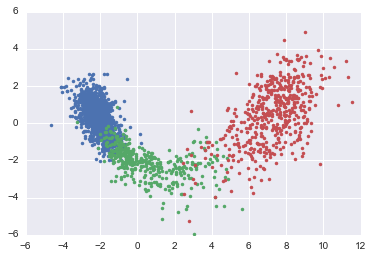

In [4]:
%matplotlib inline
clr = np.array(['blue', 'red', 'yellow'])
for j in range(3):
    plt.plot(X_lda[:, 0][y==j], X_lda[:, 1][y==j], '.')
plt.show()

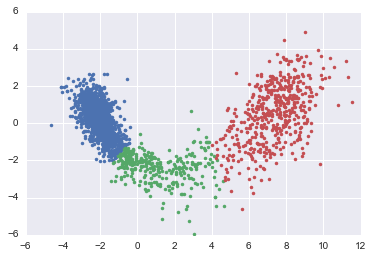

In [5]:
for j in range(3):
    plt.plot(X_lda[:, 0][preds==j], X_lda[:, 1][preds==j], '.')
plt.show()

In [6]:
lda.explained_variance_ratio_

array([  9.43670574e-01,   5.63294264e-02,   2.73575090e-29])

/home/nicolas/anaconda2/lib/python2.7/site-packages/sklearn/utils/extmath.py:368: UserWarning: The number of power iterations is increased to 7 to achieve higher precision.
  warnings.warn("The number of power iterations is increased to "


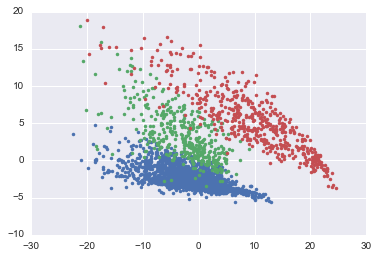

In [7]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit(X).transform(X)

for j in range(3):
    plt.plot(X_pca[:, 0][y==j], X_pca[:, 1][y==j], '.')
plt.show()

In [8]:
pca.explained_variance_ratio_

array([ 0.74205661,  0.22388633])

('pca.explained_variance_ratio_', array([ 0.74205661,  0.22388633,  0.00459413]))


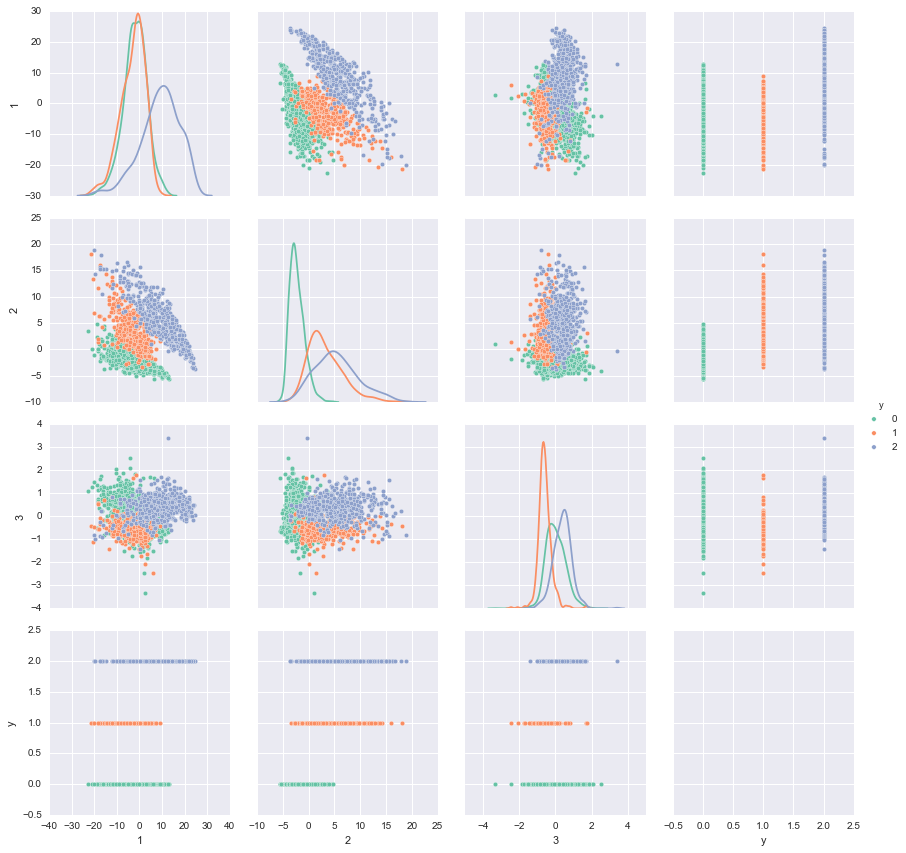

In [13]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
X_pca = pca.fit(X).transform(X)
print('pca.explained_variance_ratio_', pca.explained_variance_ratio_)
df = pd.DataFrame(X_pca, columns=['1','2','3'])
df['y'] = pd.Series(y).astype("category")
scatter_matrix_seaborn(df, y='y', size=3)

In [14]:
pca.components_

array([[ 0.02944012,  0.0176746 , -0.06347364, -0.07350447, -0.0830779 ,
        -0.09127455, -0.09855762, -0.10491589, -0.11007788, -0.11424117,
        -0.11720092, -0.11966388,  0.00496161, -0.12139025, -0.12289277,
        -0.12418654, -0.12528064, -0.12593645, -0.12681344, -0.12746098,
        -0.12813856, -0.12885531, -0.12924675, -0.00745797, -0.12964363,
        -0.12999222, -0.13018683, -0.13040969, -0.13049851, -0.13090882,
        -0.13087107, -0.13099036, -0.13112855, -0.13093267, -0.01853986,
        -0.13105297, -0.13091556, -0.13084582, -0.13083174, -0.13025976,
        -0.13060261, -0.1305436 , -0.13090161, -0.13023987, -0.12982858,
        -0.02814491, -0.12893362, -0.12864533, -0.12794839, -0.1270736 ,
        -0.12598889, -0.12486341, -0.1243443 , -0.1231697 , -0.12285161,
        -0.12246993, -0.03575695, -0.12170819, -0.1207177 , -0.12116126,
        -0.11933258, -0.11947317, -0.1182538 , -0.11798621, -0.11541466,
        -0.11545865, -0.11358885, -0.04210406, -0.1

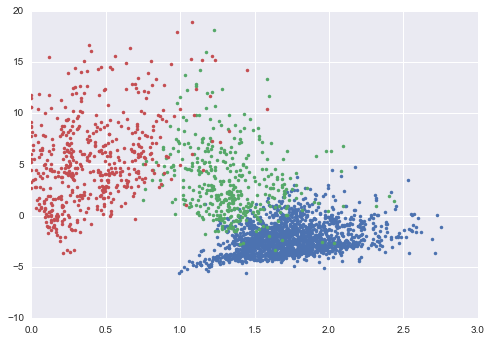

model.reconstruction_err_ 111.915173188


In [37]:
#nmf:

from sklearn.decomposition import NMF
Xpos = X - X.min(axis=0)
model = NMF(n_components=2, init='random', random_state=0)
model.fit(Xpos) 
X_nmf = model.transform(Xpos)
for j in range(3):
    plt.plot(X_nmf[:, 0][y==j], X_pca[:, 1][y==j], '.')
plt.show()
print 'model.reconstruction_err_', model.reconstruction_err_
#print 'model.components_', model.components_

model.reconstruction_err_ 80.1688828645


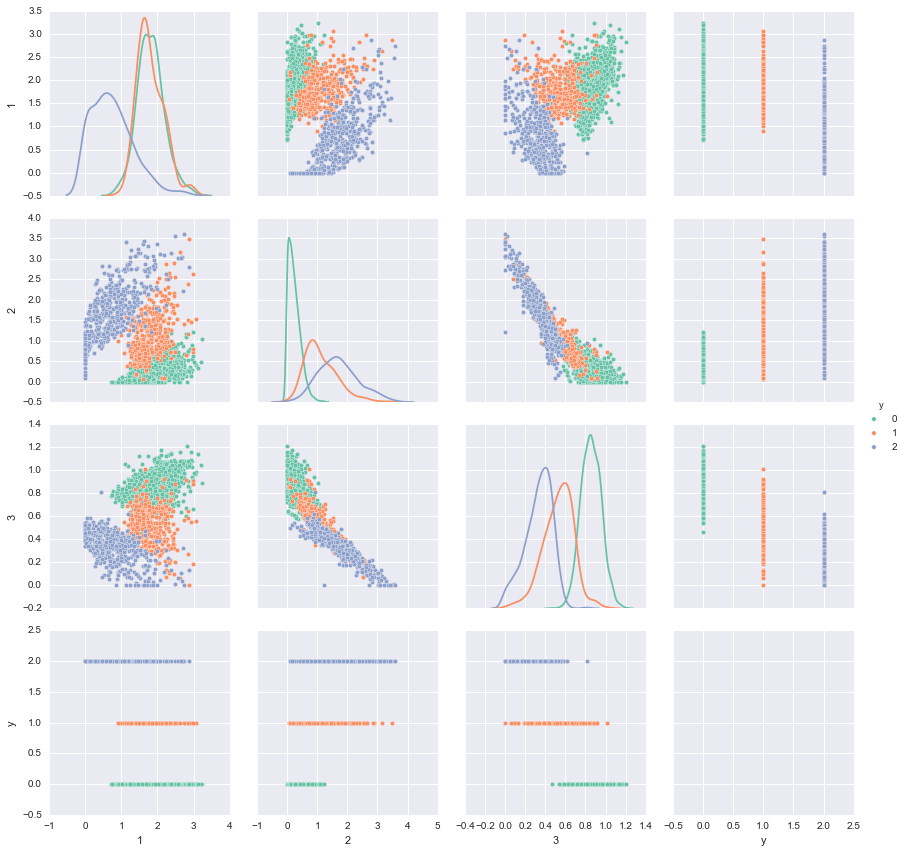

In [38]:
model = NMF(n_components=3, init='random', random_state=0)
model.fit(Xpos) 
X_nmf = model.transform(Xpos)
df = pd.DataFrame(X_nmf, columns=['1','2', '3'])
df['y'] = pd.Series(y).astype("category")
scatter_matrix_seaborn(df, y='y', size=3)
print 'model.reconstruction_err_', model.reconstruction_err_
#print 'model.components_', model.components_

model.reconstruction_err_ 75.8098166107


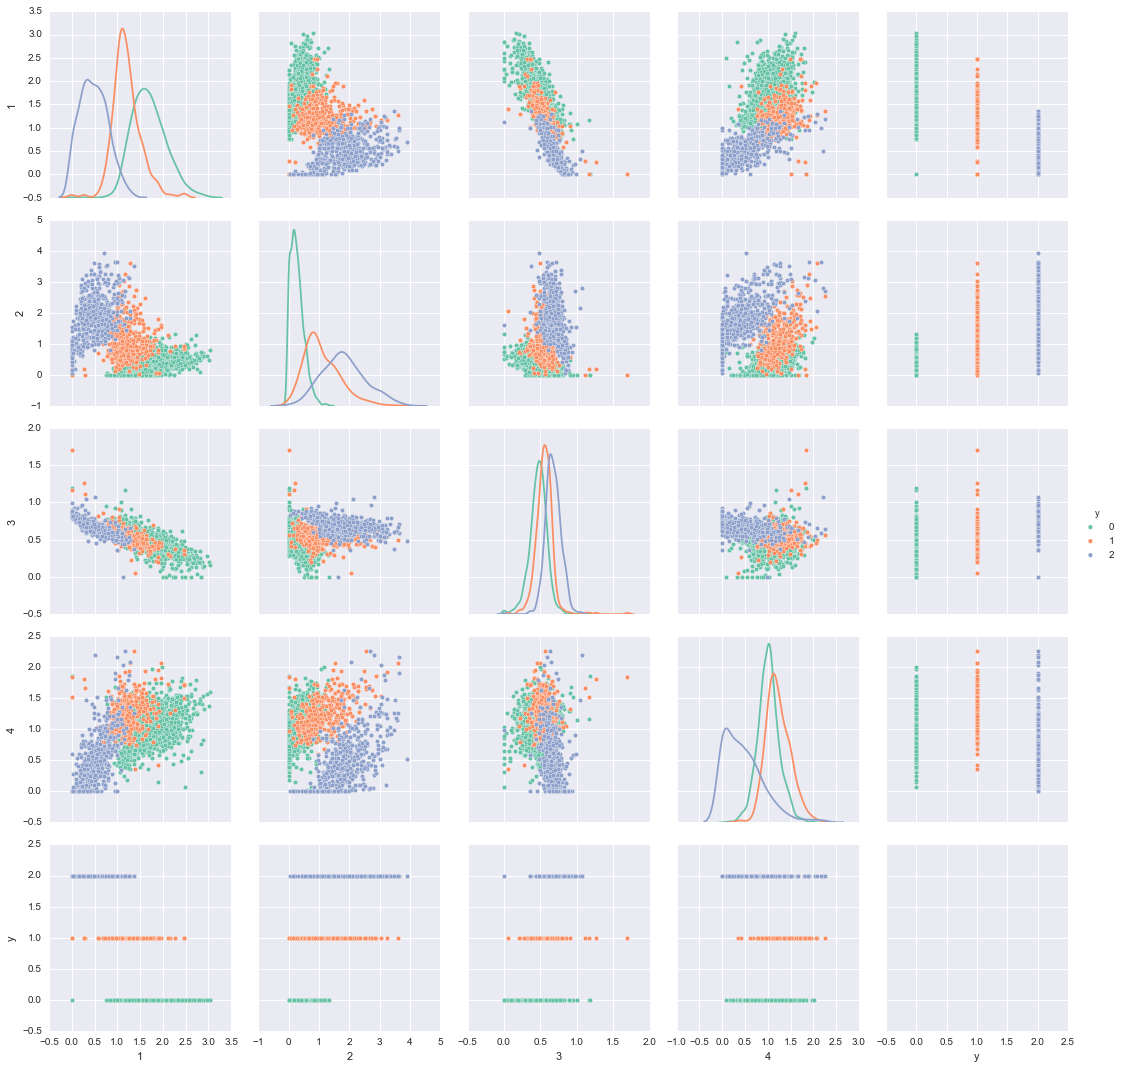

In [40]:
model = NMF(n_components=4, init='random', random_state=0)
model.fit(Xpos) 
X_nmf = model.transform(Xpos)
df = pd.DataFrame(X_nmf, columns=['1','2', '3', '4'])
df['y'] = pd.Series(y).astype("category")
scatter_matrix_seaborn(df, y='y', size=3)
print 'model.reconstruction_err_', model.reconstruction_err_
#print 'model.components_', model.components_

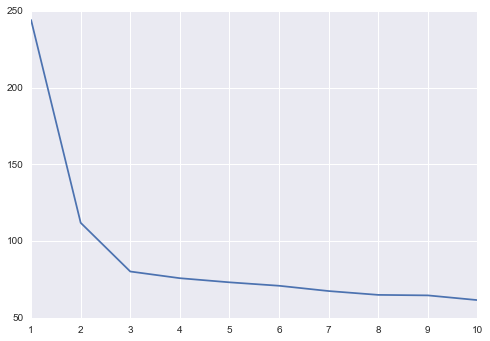

In [51]:
err = []
n_comps = range(1, 11)
for n_comp in n_comps:
    model = NMF(n_components=n_comp, init='random', random_state=0)
    model.fit(Xpos) 
    err += [model.reconstruction_err_]
plt.plot(n_comps, err)